In [43]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import gc

In [44]:
# --- SETTINGS ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_IMG_DIR = 'data/train_image/'
TEST_IMG_DIR = 'data/test_image/'
TRAIN_TEXT_DIR = 'data/train_text/'
TEST_TEXT_DIR = 'data/test_text/'
SAVE_MODEL_PATH = 'RiceSafeModel.keras'
LABEL_ENCODER_PATH = 'label_encoder.pkl'
SCALER_PATH = 'scaler.pkl'

In [45]:
DISEASE_CLASSES = ['ปกติ', 'โรคขอบใบแห้ง', 'โรคใบขีดโปร่งแสง', 'โรคใบจุดสีน้ำตาล', 'โรคไหม้']

In [46]:
# --- IMAGE PROCESSING ---
def load_image(img_path):
    try:
        img = tf_image.load_img(img_path, target_size=(224, 224))
        img_array = tf_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)
        return preprocess_input(img_array)
    except Exception as e:
        print(f"[ERROR] Failed to load {img_path}: {e}")
        return None

In [47]:
# --- TEXT EMBEDDING ---
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
text_model = AutoModel.from_pretrained("BAAI/bge-m3").to(DEVICE).eval()

@torch.no_grad()
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    outputs = text_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

In [48]:
# --- IMAGE FEATURE EXTRACTOR ---
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
mobilenet.trainable = False

def extract_img_feature(img_array):
    if isinstance(img_array, list):
        img_array = np.vstack(img_array)
    features = mobilenet.predict(img_array)
    return features

/var/folders/dq/b3nl28f51bsblfk_lyn94j240000gn/T/ipykernel_1303/503381850.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


In [49]:
# --- MAIN PAIRING FUNCTION ---
def pair_images_and_texts(batch_size=32):
    paired_data = []

    for disease_class in os.listdir(TRAIN_IMG_DIR):
        img_folder = os.path.join(TRAIN_IMG_DIR, disease_class)
        text_file = os.path.join(TRAIN_TEXT_DIR, f"{disease_class}.csv")

        if not os.path.isdir(img_folder) or not os.path.isfile(text_file):
            print(f"[SKIP] {disease_class}: Folder or CSV not found.")
            continue

        image_files = sorted([
            f for f in os.listdir(img_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        df_text = pd.read_csv(text_file)
        text_lines = df_text.iloc[:, 0].tolist()

        if len(image_files) != len(text_lines):
            print(f"[WARNING] Mismatch in {disease_class}: {len(image_files)} images vs {len(text_lines)} texts")
            continue

        for i in range(0, len(image_files), batch_size):
            batch_imgs = []
            batch_texts = []

            for img_name, text in zip(image_files[i:i+batch_size], text_lines[i:i+batch_size]):
                img_path = os.path.join(img_folder, img_name)
                img_array = load_image(img_path)
                if img_array is not None:
                    batch_imgs.append(img_array)
                    batch_texts.append(text)

            if batch_imgs and batch_texts:
                img_feats = extract_img_feature(np.vstack(batch_imgs))
                text_feats = embed_text(batch_texts)
                paired_data.extend([
                    (np.concatenate((img_feat, text_feat)), disease_class)
                    for img_feat, text_feat in zip(img_feats, text_feats)
                ])


            gc.collect()

    return paired_data

In [50]:
# --- FINALIZE TRAINING FEATURES ---
# print("[*] Pairing images and texts...")
paired_data = pair_images_and_texts(batch_size=32)
# print(f"[DONE] Paired {len(paired_data)} image-text entries.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[SKIP] .DS_Store: Folder or CSV not found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/st

In [51]:
if not paired_data:
    print("[!] No training data found.")
    exit(1)

for i, entry in enumerate(paired_data):
    if not isinstance(entry, tuple) or len(entry) != 2:
        print(f"[!] Invalid entry at index {i}: {entry}")

# --- SPLIT FEATURES AND LABELS ---
features, labels = zip(*paired_data)
X = np.array(features)
y = np.array(labels)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [52]:
# --- FEATURE SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
joblib.dump(scaler, SCALER_PATH)

# --- LABELS ENCODING ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
joblib.dump(le, LABEL_ENCODER_PATH)

['label_encoder.pkl']

In [53]:
# --- DEFINE NEURAL NETWORK ---
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(DISEASE_CLASSES), activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint(SAVE_MODEL_PATH, save_best_only=True, monitor='val_accuracy')
]

In [54]:
# --- TRAIN MODEL ---
# Training
history = model.fit(
    X_train_scaled, y_train_categorical,
    validation_data=(X_val_scaled, y_val_categorical),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
# --- SAVE MODEL & ENCODER ---
model.save(SAVE_MODEL_PATH)
joblib.dump(le, LABEL_ENCODER_PATH)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3565 - loss: 1.8828 - val_accuracy: 0.7080 - val_loss: 0.7632 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7792 - loss: 0.5904 - val_accuracy: 0.8720 - val_loss: 0.4127 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8727 - loss: 0.3611 - val_accuracy: 0.9320 - val_loss: 0.2541 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9069 - loss: 0.2674 - val_accuracy: 0.9600 - val_loss: 0.1673 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.1782 - val_accuracy: 0.9800 - val_loss: 0.1240 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9716 - loss: 0.1154 - val_accuracy: 0.9880 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9797

['label_encoder.pkl']

In [55]:
# --- MAIN PAIRING FUNCTION ---
def pair_test_images_and_texts(batch_size=32):
    test_paired_data = []

    for test_disease_class in os.listdir(TEST_IMG_DIR):
        test_img_folder = os.path.join(TEST_IMG_DIR, test_disease_class)
        test_text_file = os.path.join(TEST_TEXT_DIR, f"{test_disease_class}.csv")

        if not os.path.isdir(test_img_folder) or not os.path.isfile(test_text_file):
            print(f"[SKIP] {test_disease_class}: Folder or CSV not found.")
            continue

        test_image_files = sorted([
            f for f in os.listdir(test_img_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        test_df_text = pd.read_csv(test_text_file)
        test_text_lines = test_df_text.iloc[:, 0].tolist()

        if len(test_image_files) != len(test_text_lines):
            print(f"[WARNING] Mismatch in {test_disease_class}: {len(test_image_files)} images vs {len(test_text_lines)} texts")
            continue

        for i in range(0, len(test_image_files), batch_size):
            batch_test_imgs = []
            batch_test_texts = []

            for img_name, text in zip(test_image_files[i:i+batch_size], test_text_lines[i:i+batch_size]):
                img_path = os.path.join(test_img_folder, img_name)
                img_array = load_image(img_path)
                if img_array is not None:
                    batch_test_imgs.append(img_array)
                    batch_test_texts.append(text)

            if batch_test_imgs and batch_test_texts:
                test_img_feats = extract_img_feature(np.vstack(batch_test_imgs))
                test_text_feats = embed_text(batch_test_texts)
                test_paired_data.extend([
                    (np.concatenate((img_feat, text_feat)), test_disease_class)
                    for img_feat, text_feat in zip(test_img_feats, test_text_feats)
                ])

            gc.collect()

    return test_paired_data

In [56]:
# --- FINALIZE TEST FEATURES ---
test_paired_data = pair_test_images_and_texts(batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
[SKIP] .DS_Store: Folder or CSV not found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


In [57]:
# --- PREPARE TEST DATA ---
if not test_paired_data:
    print("[ERROR] No test data was paired successfully.")
    exit(1)

# Split test data into features and labels
test_features_raw, test_labels_raw = zip(*test_paired_data)
X_test = np.array(test_features_raw)
y_test = np.array(test_labels_raw)

# Load the scaler and label encoder
scaler = joblib.load(SCALER_PATH)
le = joblib.load(LABEL_ENCODER_PATH)

# Preprocess test data
X_test_scaled = scaler.transform(X_test)
y_test_encoded = le.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded)

In [58]:
# --- LOAD THE SAVED MODEL ---
model = load_model(SAVE_MODEL_PATH)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
# --- EVALUATE ON TEST SET ---
# Get loss and accuracy
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9307 - loss: 0.1749  

Test Accuracy: 0.9484
Test Loss: 0.1264


In [60]:
predictions = model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [61]:
# Classification Report
report = classification_report(y_test_encoded, predicted_labels,
                              target_names=DISEASE_CLASSES)
print("\nClassification Report:")
report


Classification Report:


'                  precision    recall  f1-score   support\n\n            ปกติ       1.00      1.00      1.00        62\n    โรคขอบใบแห้ง       0.98      0.95      0.97        62\nโรคใบขีดโปร่งแสง       0.95      1.00      0.98        62\nโรคใบจุดสีน้ำตาล       0.87      0.95      0.91        62\n         โรคไหม้       0.95      0.84      0.89        62\n\n        accuracy                           0.95       310\n       macro avg       0.95      0.95      0.95       310\n    weighted avg       0.95      0.95      0.95       310\n'

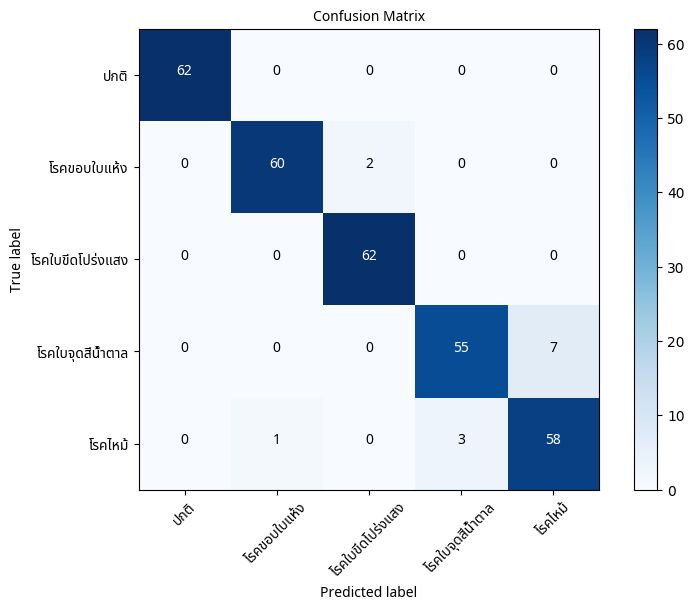

In [62]:
# --- VISUALIZE RESULTS ---
font_path = 'fonts/NotoSansThai-VariableFont_wdth,wght.ttf'
thai_font = fm.FontProperties(fname=font_path)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontproperties=thai_font)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    # Use Thai font for tick labels
    plt.xticks(tick_marks, classes, rotation=45, fontproperties=thai_font)
    plt.yticks(tick_marks, classes, fontproperties=thai_font)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontproperties=thai_font)

    plt.tight_layout()
    plt.ylabel('True label', fontproperties=thai_font)
    plt.xlabel('Predicted label', fontproperties=thai_font)
    plt.show()


# Plot confusion matrix

plot_confusion_matrix(cm, DISEASE_CLASSES)

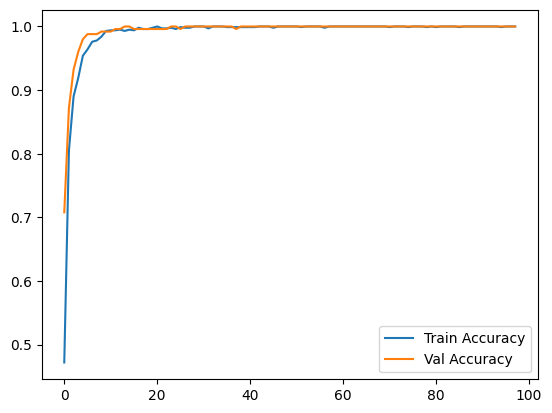

In [63]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()